In [1]:
import os
import re
import yaml
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


from dataset import JetSubstructureDataset
from models import JetSubstructureNeqModel
from ensemble import AveragingJetNeqModel, BaggingJetNeqModel, AdaBoostJetNeqModel

JSC_INPUT_LEN = 16
JSC_OUTPUT_LEN = 5
JSC_DATASET_LEN = 789_444

In [2]:
dataset_file = "data/processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z"
dataset_config = "config/yaml_IP_OP_config.yml"

In [65]:
def set_random_seeds(exp_config, cuda=False):
    with open(exp_config, "r") as f:
        config = yaml.safe_load(f)
    # Set random seeds
    random.seed(config["seed"])
    np.random.seed(config["seed"])
    torch.manual_seed(config["seed"])
    os.environ["PYTHONHASHSEED"] = str(config["seed"])
    if cuda:
        torch.cuda.manual_seed_all(config["seed"])
        torch.backends.cudnn.deterministic = True

def load_dataset(dataset_file, dataset_config):
     # Fetch the datasets
    dataset = {}
    dataset["train"] = JetSubstructureDataset(
        dataset_file, dataset_config, split="train"
    )
    # This dataset is so small, we'll just use the training set as the validation set, otherwise we may have too few trainings examples to converge.
    dataset["valid"] = JetSubstructureDataset(
        dataset_file, dataset_config, split="train"
    )
    dataset["test"] = JetSubstructureDataset(
        dataset_file, dataset_config, split="test"
    )
    return dataset

def load_model(exp_config, checkpoint=None):
    with open(exp_config, "r") as f:
        config = yaml.safe_load(f)
    # Instantiate model
    config["input_length"] = JSC_INPUT_LEN
    config["output_length"] = JSC_OUTPUT_LEN
    # print(f"Input length: {config['input_length']}")
    # print(f"Output length: {config['output_length']}")

    # Ensemble settings
    quantize_avg = False
    if "quantize_avg" in config:
        quantize_avg = config["quantize_avg"]
    if "post_transform_output" not in config:
        config["post_transform_output"] = True # Default
    if "same_output_scale" not in config:
        config["same_output_scale"] = False # Default
    if "same_input_scale" not in config:
        config["same_input_scale"] = False # Default
    
    if "ensemble_method" in config:
        if config["ensemble_method"] == "averaging":
            # print("Averaging ensemble method")
            model = AveragingJetNeqModel(
                config, config["ensemble_size"], quantize_avg=quantize_avg
            )
        elif config["ensemble_method"] == "bagging":
            # print("Bagging ensemble method")
            if "independent" not in config:
                config["independent"] = False # Default
            model = BaggingJetNeqModel(
                config,
                config["ensemble_size"],
                quantize_avg=quantize_avg,
                single_model_mode=False,
            )
        elif config["ensemble_method"] == "adaboost":
            # print("AdaBoost ensemble method")
            if "independent" not in config:
                config["independent"] = False # Default
            model = AdaBoostJetNeqModel(
                config,
                config["ensemble_size"],
                JSC_DATASET_LEN,
                quantize_avg=quantize_avg,
                single_model_mode=False,
            )
        else:
            raise ValueError(f"Unknown ensemble method: {config['ensemble_method']}")
    else:  # Single model learning
        model = JetSubstructureNeqModel(config)
    if checkpoint is not None:
        print(f"Loading pre-trained checkpoint {checkpoint}")
        checkpoint = torch.load(checkpoint, map_location="cpu")
        model.load_state_dict(checkpoint["model_dict"], strict=False)

    # print(f"Model: {model.__class__.__name__}")

    return model

def compute_cartesian_distance(model):
    """
    Compute Cartesian distance between input sparsity masks of the ensemble members
    """
    ensemble_size = model.num_models
    input_masks = []
    for i in range(ensemble_size):
        mask = model.ensemble[i].module_list[0].fc.mask.mask.numpy()
        input_masks.append(mask)
    input_masks = np.array(input_masks)
    print(f"input masks shape: {input_masks.shape}")
    # print(input_masks)
    cartesian_distances = np.zeros((ensemble_size, ensemble_size))
    for i in range(ensemble_size):
        for j in range(ensemble_size):
            # dist = np.linalg.norm(input_masks[i] - input_masks[j])
            dist = np.sqrt(np.sum(np.abs(input_masks[i] - input_masks[j])))
            # print(f"dist = {dist}")
            cartesian_distances[i, j] = dist
    total_distance = np.sum(cartesian_distances)
    return cartesian_distances, total_distance

def compute_total_cartesian_distance(exp_dir, model_tag=None, checkpoint_file_name="best_accuracy.pth"):
    # Compute for every model in the directory
    dist_arrays = []
    total_dists = []
    models = []
    for model_dir in os.listdir(exp_dir):
        if model_tag not in model_dir:
            continue
        config = os.path.join(exp_dir, model_dir, "hparams.yml")
        ckpt = os.path.join(exp_dir, model_dir, checkpoint_file_name)
        set_random_seeds(config)
        dataset = load_dataset(dataset_file, dataset_config)
        model = load_model(config, dataset, checkpoint=ckpt)
        models.append(model)
        dists, total_dist = compute_cartesian_distance(model)
        total_dists.append(total_dist)
        dist_arrays.append(dists)
    return total_dists, dist_arrays, models

def count_input_connections(model):
    """
    Count number of times each input is connected to a weight in first layer of each model in the ensemble
    """
    ensemble_size = model.num_models
    sparsity_mask_shape = model.ensemble[0].module_list[0].fc.mask.mask.numpy().shape
    input_connections = np.zeros((ensemble_size, sparsity_mask_shape[1]))
    # Sum accross rows to get total number of connections for each input
    for i in range(ensemble_size):
        mask = model.ensemble[i].module_list[0].fc.mask.mask.numpy()
        # print(f"mask shape: {mask.shape}")
        connections = np.sum(mask, axis=0)
        # print(f"connections shape: {connections.shape}")
        input_connections[i] += connections 
    # print(f"input connections shape: {input_connections.shape}")
    ensemble_connections = np.sum(input_connections, axis=0)
    return input_connections, ensemble_connections

def compute_input_connections_all(exp_dir, model_tag=None, checkpoint_file_name="best_accuracy.pth", normalize=False):
    # Compute for every model in the directory
    input_conn_arrays = []
    ensemble_conn_arrays = []
    models = []
    for model_dir in os.listdir(exp_dir):
        if model_tag not in model_dir:
            continue
        config = os.path.join(exp_dir, model_dir, "hparams.yml")
        ckpt = os.path.join(exp_dir, model_dir, checkpoint_file_name)
        set_random_seeds(config)
        model = load_model(config, checkpoint=ckpt)
        models.append(model)
        input_conns, ensemble_conns = count_input_connections(model)
        input_conn_arrays.append(input_conns)
        ensemble_conns /= model.num_models # Normalize by number of models
        print(f"Num models: {model.num_models}")
        if normalize:
            # Normalize to where 1.0 means each input is uniformly represented among the neurons
            mask = model.ensemble[0].module_list[0].fc.mask.mask.numpy()
            with open(config, "r") as f:
                config = yaml.safe_load(f)
            # print(f"mask shape: {mask.shape}")
            # print(f"fanin: {config['input_fanin']}")
            # print(f"fanin: {int(config['input_fanin'])}")
            ensemble_conns /= int(config["input_fanin"]) * mask.shape[0] / mask.shape[1]
        ensemble_conn_arrays.append(ensemble_conns)
    # print(f"ensemble_conn_arrays: {ensemble_conn_arrays}")
    # Sort by ensemble size
    ensemble_conn_arrays = np.array(ensemble_conn_arrays)
    models = np.array(models)
    sort_indices = np.argsort([m.num_models for m in models])
    ensemble_conn_arrays = ensemble_conn_arrays[sort_indices]
    models = models[sort_indices]
    # print(f"sorted ensemble_conn_arrays: {ensemble_conn_arrays}")
    return input_conn_arrays, ensemble_conn_arrays, models

def plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag=None):
    """
    Plot heatmap of number of neurons connected to each input element in each ensemble
    """
    # ensemble_avg_conn_arrays = np.array([ens / m.num_models for ens, m in zip(ensemble_conn_arrays, models)])
    # print(f"ensemble_avg_conn_arrays.shape: {ensemble_conn_arrays.shape}")
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(ensemble_conn_arrays, cmap="viridis", annot=True, ax=ax, cbar=True, fmt=".1f")
    ax.set_ylabel("Ensemble size")
    ax.set_yticks(np.arange(len(models)) + 0.5, labels=(2 ** np.arange(1, len(models) + 1)))
    ax.set_xlabel("Input element index")
    ax.set_title(f"Average Number of Neurons Connected to Input Elements")
    fig.savefig(f"./plots/ensemble_avg_input_connections_{model_tag}.pdf")

## Averaging Sparsity Masks w/Cartesian Distance

In [8]:
config = "./averaging/averaging_small_ensemble_size2/hparams.yml"
ckpt="./averaging/averaging_small_ensemble_size2/best_accuracy.pth"
set_random_seeds(config)
dataset = load_dataset(dataset_file, dataset_config)
model = load_model(config, dataset, checkpoint=ckpt)
dists, total_dist = compute_cartesian_distance(model)

Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size2/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (2, 64, 16)
dist = 0.0
dist = 17.435596466064453
dist = 17.435596466064453
dist = 0.0


In [9]:
dists, total_dist

(array([[ 0.        , 17.43559647],
        [17.43559647,  0.        ]]),
 34.871192932128906)

In [11]:
total_dists, dist_arrays, models = compute_total_cartesian_distance("./averaging", model_tag="averaging_small_ensemble_size")

Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size4/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (4, 64, 16)
dist = 0.0
dist = 17.435596466064453
dist = 17.549928665161133
dist = 18.055469512939453
dist = 17.435596466064453
dist = 0.0
dist = 17.14642906188965
dist = 18.275667190551758
dist = 17.549928665161133
dist = 17.14642906188965
dist = 0.0
dist = 17.77638816833496
dist = 18.055469512939453
dist = 18.275667190551758
dist = 17.77638816833496
dist = 0.0
Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size8/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (8, 64, 16)
dist = 0.0
dist = 17.435596466064453
dist = 17.549928665161133
dist = 18.055469512939453
dist = 17.6068172454834
dist = 17.262676239013672
dist = 18.0
dist = 17.83255386352539
dist = 17.435596466064453
dist = 0.0
dist = 17.146

In [12]:
mdt = zip(models, dist_arrays, total_dists)
mdt = sorted(mdt, key=lambda x: x[0].num_models)

for model, dist_array, total_dist in mdt:
    print(f"Model: {model.__class__.__name__}")
    print(f"Ensemble size: {model.num_models}")
    print(f"Total Cartesian distance: {total_dist}")
    print(dist_array)

Model: AveragingJetNeqModel
Ensemble size: 2
Total Cartesian distance: 34.871192932128906
[[ 0.         17.43559647]
 [17.43559647  0.        ]]
Model: AveragingJetNeqModel
Ensemble size: 4
Total Cartesian distance: 212.4789581298828
[[ 0.         17.43559647 17.54992867 18.05546951]
 [17.43559647  0.         17.14642906 18.27566719]
 [17.54992867 17.14642906  0.         17.77638817]
 [18.05546951 18.27566719 17.77638817  0.        ]]
Model: AveragingJetNeqModel
Ensemble size: 8
Total Cartesian distance: 994.7839431762695
[[ 0.         17.43559647 17.54992867 18.05546951 17.60681725 17.26267624
  18.         17.83255386]
 [17.43559647  0.         17.14642906 18.27566719 17.83255386 17.02938652
  18.05546951 17.88854408]
 [17.54992867 17.14642906  0.         17.77638817 17.83255386 17.77638817
  17.49285507 17.72004509]
 [18.05546951 18.27566719 17.77638817  0.         17.72004509 17.88854408
  17.72004509 18.11077118]
 [17.60681725 17.83255386 17.83255386 17.72004509  0.         17.720

In [13]:
total_dists, dist_arrays, models = compute_total_cartesian_distance("./averaging", model_tag="averaging_medium_ensemble_size")
mdt = zip(models, dist_arrays, total_dists)
mdt = sorted(mdt, key=lambda x: x[0].num_models)

for model, dist_array, total_dist in mdt:
    print(f"Model: {model.__class__.__name__}")
    print(f"Ensemble size: {model.num_models}")
    print(f"Total Cartesian distance: {total_dist}")
    print(dist_array)

Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size32/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (32, 64, 16)
dist = 0.0
dist = 19.235383987426758
dist = 19.748416900634766
dist = 19.493589401245117
dist = 19.79899024963379
dist = 19.748416900634766
dist = 19.899747848510742
dist = 19.748416900634766
dist = 19.235383987426758
dist = 19.235383987426758
dist = 19.94993782043457
dist = 19.84943389892578
dist = 19.493589401245117
dist = 19.287302017211914
dist = 19.442222595214844
dist = 19.79899024963379
dist = 19.748416900634766
dist = 20.19900894165039
dist = 19.493589401245117
dist = 19.899747848510742
dist = 19.84943389892578
dist = 19.339078903198242
dist = 19.595918655395508
dist = 19.339078903198242
dist = 19.02629852294922
dist = 19.646883010864258
dist = 19.84943389892578
dist = 19.442222595214844
dist = 19.646883010864258
dist = 19.442222595214844
dist = 19.84943389892578
dist

In [6]:
total_dists, dist_arrays, models = compute_total_cartesian_distance("./averaging", model_tag="small_same_output_scale_post_trans_ensemble_size2")
mdt = zip(models, dist_arrays, total_dists)
mdt = sorted(mdt, key=lambda x: x[0].num_models)

for model, dist_array, total_dist in mdt:
    print(f"Model: {model.__class__.__name__}")
    print(f"Ensemble size: {model.num_models}")
    print(f"Total Cartesian distance: {total_dist}")
    print(dist_array)

Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/small_same_output_scale_post_trans_ensemble_size2_seed6/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (2, 64, 16)
Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/small_same_output_scale_post_trans_ensemble_size2_seed1/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (2, 64, 16)
Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/small_same_output_scale_post_trans_ensemble_size2/best_accuracy.pth
Model: AveragingJetNeqModel
input masks shape: (2, 64, 16)
Model: AveragingJetNeqModel
Ensemble size: 2
Total Cartesian distance: 36.110939025878906
[[ 0.         18.05546951]
 [18.05546951  0.        ]]
Model: AveragingJetNeqModel
Ensemble size: 2
Total Cartesian distance: 35.32704162597656
[[ 0.         17.66352081]
 [17.66352081  0.        ]]
Model: Av

## Averaging Sparsity Masks by Counting Input Connections

### JSC-S

In [28]:
# Counting input connections for one model
config = "./averaging/averaging_small_ensemble_size2/hparams.yml"
ckpt="./averaging/averaging_small_ensemble_size2/best_accuracy.pth"
set_random_seeds(config)
# dataset = load_dataset(dataset_file, dataset_config)
model = load_model(config, checkpoint=ckpt)
input_connections, ensemble_connections = count_input_connections(model)
print("input connections")
print(input_connections)
print("ensemble connections")
print(ensemble_connections)

Input length: 16
Output length: 5
Averaging ensemble method
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size2/best_accuracy.pth
Model: AveragingJetNeqModel
mask shape: (64, 16)
connections shape: (16,)
mask shape: (64, 16)
connections shape: (16,)
input connections shape: (2, 16)
input connections
[[14. 15. 16.  8. 11. 11. 10. 12. 12. 12.  8. 12. 12. 21. 10.  8.]
 [17. 10. 12. 12. 13. 10.  9. 17.  8. 16. 10. 16. 14. 10.  9.  9.]]
ensemble connections
[31. 25. 28. 20. 24. 21. 19. 29. 20. 28. 18. 28. 26. 31. 19. 17.]


Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size64/best_accuracy.pth
Num models: 64
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size128/best_accuracy.pth
Num models: 128
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size32/best_accuracy.pth
Num models: 32
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size16/best_accuracy.pth
Num models: 16


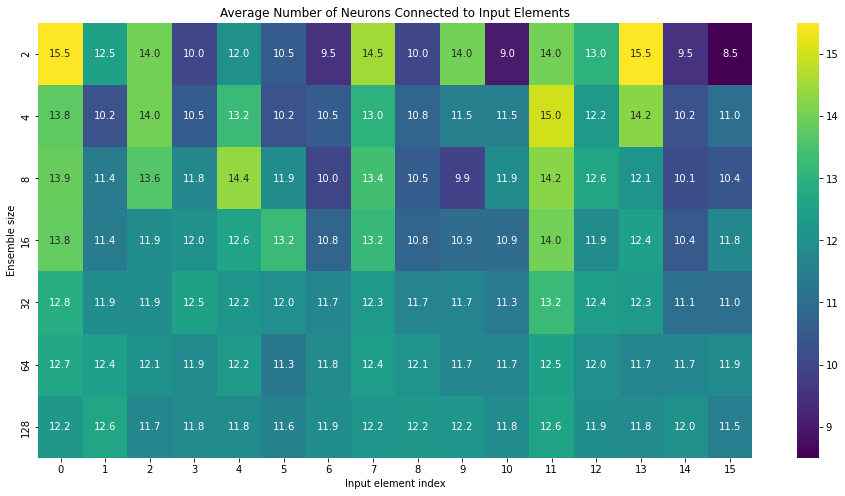

In [66]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all("./averaging", model_tag="averaging_small_ensemble_size")
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_s")

Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size64/best_accuracy.pth
Num models: 64
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size128/best_accuracy.pth
Num models: 128
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size32/best_accuracy.pth
Num models: 32
Loading pre-trained checkpoint ./averaging/averaging_small_ensemble_size16/best_accuracy.pth
Num models: 16


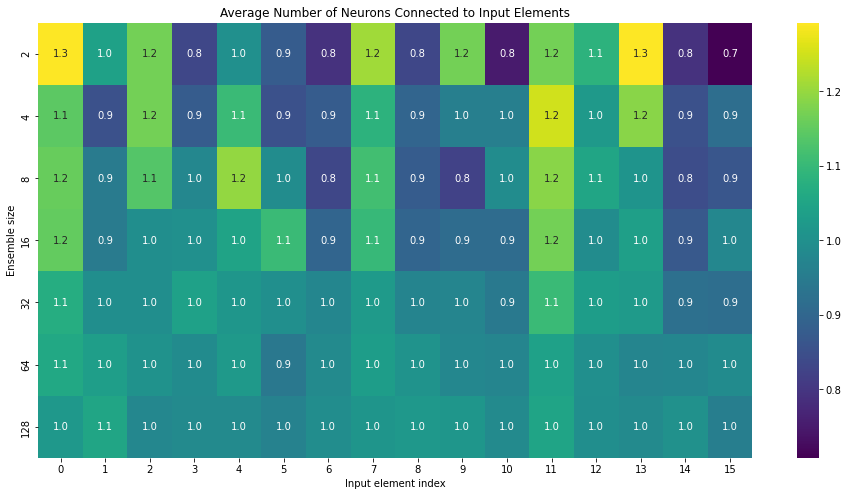

In [67]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all(
    "./averaging", model_tag="averaging_small_ensemble_size", normalize=True
)
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_s_normalized")

Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size32/best_accuracy.pth
Num models: 32
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size16/best_accuracy.pth
Num models: 16


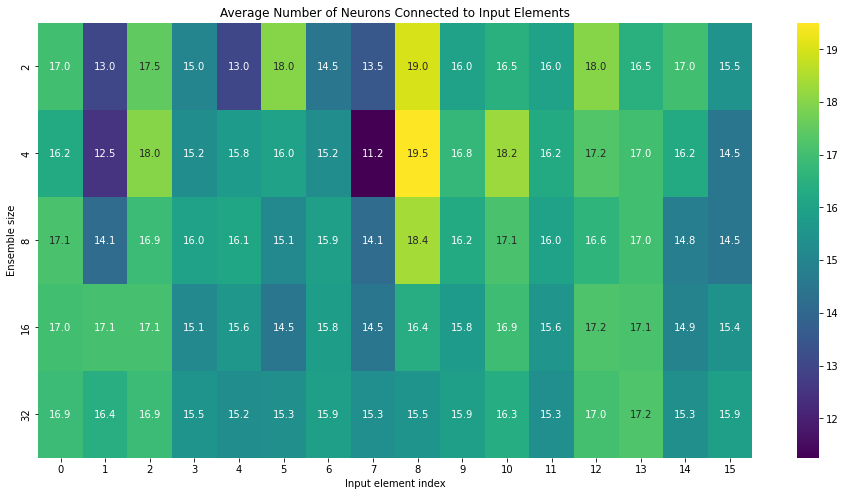

In [68]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all(
    "./averaging", model_tag="averaging_medium_ensemble_size"
)
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_m")

Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size32/best_accuracy.pth
Num models: 32
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ./averaging/averaging_medium_ensemble_size16/best_accuracy.pth
Num models: 16


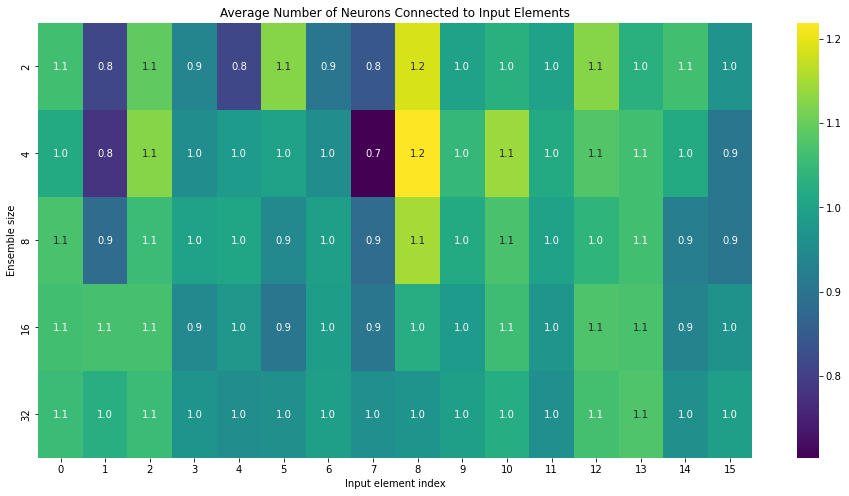

In [69]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all(
    "./averaging", model_tag="averaging_medium_ensemble_size", normalize=True,
)
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_m_normalized")

Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size16/best_accuracy.pth
Num models: 16
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size32/best_accuracy.pth
Num models: 32


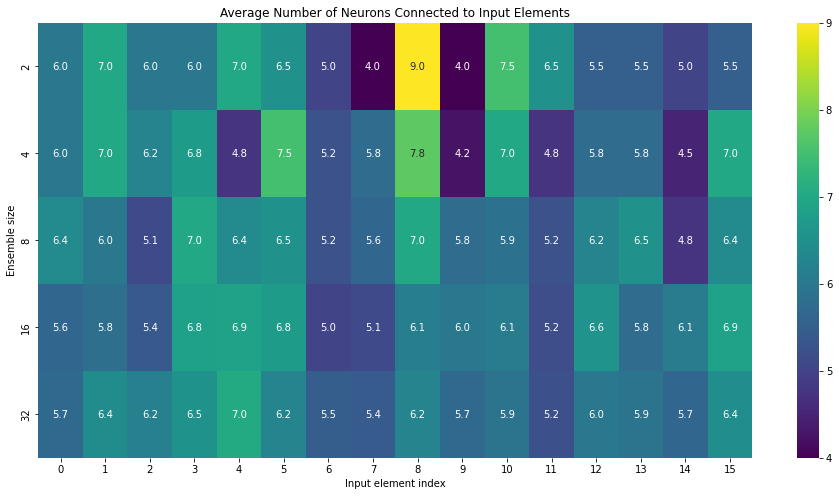

In [70]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all(
    "../../../dev-logicnets/model_ckpts/jet_substructure/averaging", model_tag="averaging_large_ensemble_size")
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_l")

Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size8/best_accuracy.pth
Num models: 8
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size4/best_accuracy.pth
Num models: 4
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size16/best_accuracy.pth
Num models: 16
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size2/best_accuracy.pth
Num models: 2
Loading pre-trained checkpoint ../../../dev-logicnets/model_ckpts/jet_substructure/averaging/averaging_large_ensemble_size32/best_accuracy.pth
Num models: 32


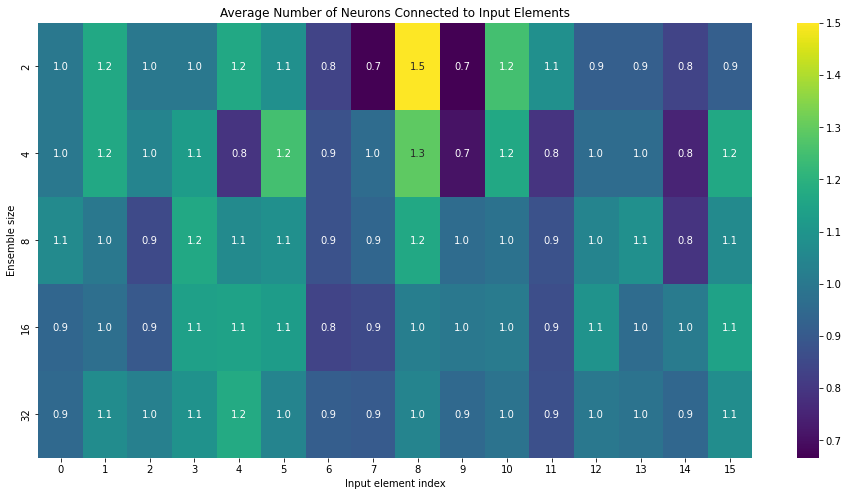

In [71]:
input_conn_arrays, ensemble_conn_arrays, models = compute_input_connections_all(
    "../../../dev-logicnets/model_ckpts/jet_substructure/averaging", model_tag="averaging_large_ensemble_size", normalize=True
)
plot_ensemble_input_connections_heatmap(ensemble_conn_arrays, models, model_tag="jsc_l_normalized")

In [106]:
exp_dir = "./jsc_single_models"
model_dir = "uniform_input_small_seed0"

config = os.path.join(exp_dir, model_dir, "hparams.yml")
ckpt = os.path.join(exp_dir, model_dir, "best_accuracy.pth")
set_random_seeds(config)
model = load_model(config, checkpoint=ckpt)
sparsity_mask_shape = model.module_list[0].fc.mask.mask.numpy().shape
input_connections = np.zeros((1, sparsity_mask_shape[1]))
mask = model.module_list[0].fc.mask.mask.numpy()
print(f"mask shape: {mask.shape}")
connections = np.sum(mask, axis=0)
input_connections += connections 
print(f"input connections shape: {input_connections.shape}")
print(f"input connections: {input_connections}")

Input length: 16
Output length: 5
Loading pre-trained checkpoint ./jsc_single_models/uniform_input_small_seed0/best_accuracy.pth
Model: JetSubstructureNeqModel
mask shape: (64, 16)
input connections shape: (1, 16)
input connections: [[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]]
